In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from torchdrive.data import collate
from torchdrive.notebook import display_img, display_color, display, to_pil_image
from torchdrive.transforms.batch import NormalizeCarPosition
from configs.simplebev3d_multi_pose import CONFIG
import torch


NUSCENES = True
if True:
    dataset = CONFIG.create_dataset(smoke=True)
elif NUSCENES:
    from torchdrive.datasets.nuscenes_dataset import NuscenesDataset
    dataset = NuscenesDataset(
        data_dir="../../../ext3/nuscenes",
        version="v1.0-mini",
        lidar=True,
        num_frames=5,
    )
else:
    from torchdrive.datasets.rice import MultiCamDataset
    dataset = MultiCamDataset(
        index_file="../../openape/snapshots/out-mar23/index.txt",
        mask_dir="../../openape/masks",
        cameras=["main", "narrow", "fisheye", "leftpillar", "leftrepeater", "rightpillar", "rightrepeater", "backup"],
        cam_shape=(480, 640),
        nframes_per_point=5,
        limit_size=1000,
        dynamic=True,
    )
print(len(dataset))
# 120 has LIDAR alignment issues
# 500 has it fixed
example = dataset[500]
assert example is not None

#transform = NormalizeCarPosition(start_frame=0)
#batch = collate([example])
#batch = transform(batch)

#for cam in a.cameras:
#    display_img(example.color[cam][0].float())

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.693 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Found 2342 scenes for CAM_FRONT
Found 2342 samples for CAM_FRONT
Found 2344 scenes for CAM_FRONT_LEFT
Found 2344 samples for CAM_FRONT_LEFT
Found 2338 scenes for CAM_FRONT_RIGHT
Found 2338 samples for CAM_FRONT_RIGHT
Found 2315 scenes for CAM_BACK
Found 2315 samples for CAM_BACK
Found 2327 scenes for CAM_BACK_LEFT
Found 2327 samples for CAM_BACK_LEFT
Found 2342 scenes for CAM_BACK_RIGHT
Found 2342 samples for CAM_BACK_RIGHT
failed to match 10/14008 frames
2342


In [3]:

device = torch.device('cpu')
model = CONFIG.create_model(device=device)

/home/tristanr/.conda/envs/torchdrive-3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tristanr/.conda/envs/torchdrive-3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_800MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_800MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
%autoreload 2
from torch import nn
from torchdrive.transforms.batch import NormalizeCarPosition

device = torch.device('cuda')
CONFIG.cam_features_mask_ratio = 0.0
model = CONFIG.create_model(device=device)

model.transform=NormalizeCarPosition(2)

def replace(m):
    for name, module in m.named_children():
        if isinstance(module, (
            nn.BatchNorm3d, 
            nn.BatchNorm2d, 
            nn.BatchNorm1d,
            nn.InstanceNorm2d,
            nn.InstanceNorm3d,
            nn.ReLU,
        )):
            setattr(m, name, nn.Identity())
        elif isinstance(module, nn.Conv2d):
            if module.bias is not None:
                module.bias.data.zero_()
            weight = module.weight.data
            weight.zero_()
            in_ch, out_ch, h, w = weight.shape
            ch = h // 2
            cw = w // 2
            weight[:, :, ch, cw] = 1.0/in_ch

            if h == 1 and w == 1 and in_ch == out_ch and module.stride == (1, 1):
                setattr(m, name, nn.Identity())
        elif isinstance(module, nn.Conv3d):
            if module.bias is not None:
                module.bias.data.zero_()
            weight = module.weight.data
            weight.zero_()
            in_ch, out_ch, h, w, d = weight.shape
            ch = h // 2
            cw = w // 2
            cd = d // 2
            weight[:, :, ch, cw, cd] = 1.0/in_ch
        elif isinstance(module, nn.Embedding):
            module.weight.data.zero_()
        elif isinstance(module, nn.Upsample):
            module.mode = "nearest"
            module.align_corners = None
        #else:
            #raise RuntimeError(f"found {module}")
            #print(module.weight.shape)
    #print(m)
model.apply(replace)

class ZeroOutput(nn.Module):
    def __init__(self, module: nn.Module) -> None:
        super().__init__()
        self.module = module

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.module(x) * 0

def disable_upsample(m):
    for name, module in m.named_children():
        if isinstance(module, nn.Upsample):
            setattr(m, name, ZeroOutput(module))


# this effectively disables the fpn
model.backbone.fpn.apply(disable_upsample)

class NoopFPN(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return (x, x, x, x), {}

model.backbone.fpn = NoopFPN().to(device)

bev/bev0


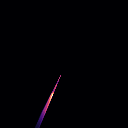

bev/bev1


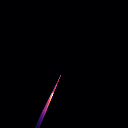

bev/bev2


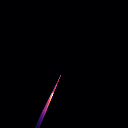

bev/bev3


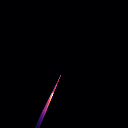

bev/hr_bev


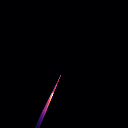

voxel_jepa-grid/0/z


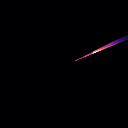

voxel_jepa-CAM_FRONT/0/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT/0/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT/0/target


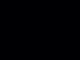

voxel_jepa-CAM_FRONT/0/predicted


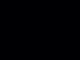

voxel_jepa-CAM_FRONT/0/color


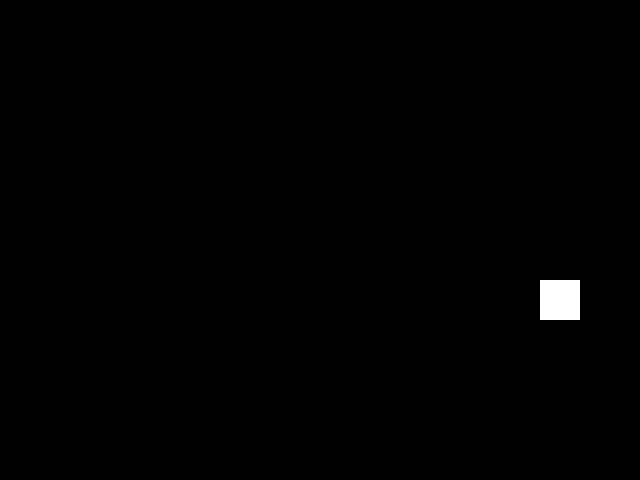

voxel_jepa-CAM_FRONT_LEFT/0/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_LEFT/0/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_LEFT/0/target


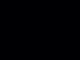

voxel_jepa-CAM_FRONT_LEFT/0/predicted


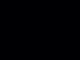

voxel_jepa-CAM_FRONT_LEFT/0/color


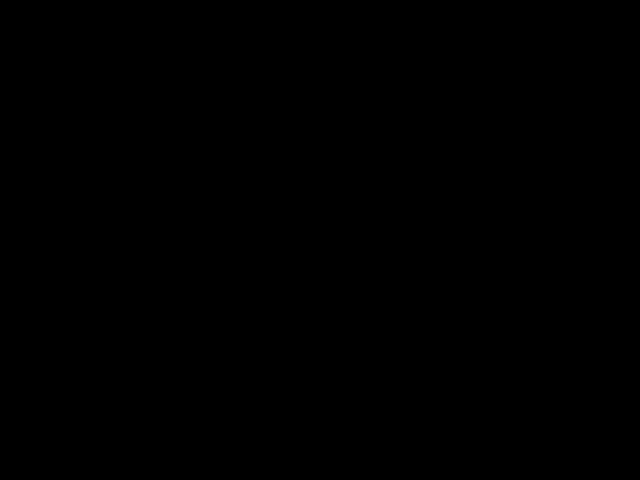

voxel_jepa-CAM_FRONT_RIGHT/0/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_RIGHT/0/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_RIGHT/0/target


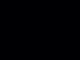

voxel_jepa-CAM_FRONT_RIGHT/0/predicted


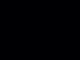

voxel_jepa-CAM_FRONT_RIGHT/0/color


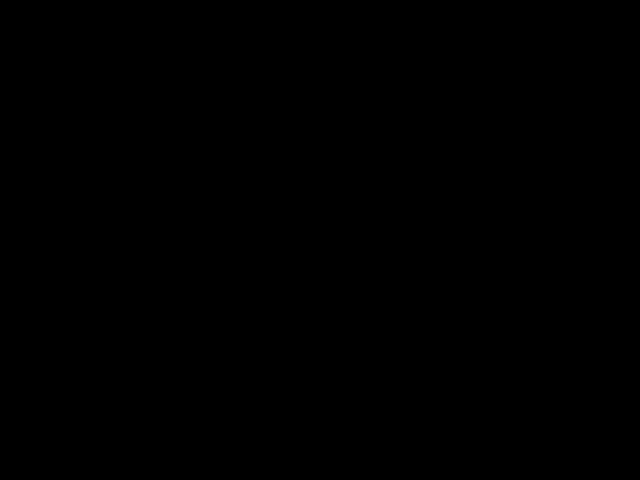

voxel_jepa-CAM_BACK/0/target


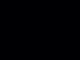

voxel_jepa-CAM_BACK/0/predicted


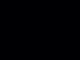

voxel_jepa-CAM_BACK/0/color


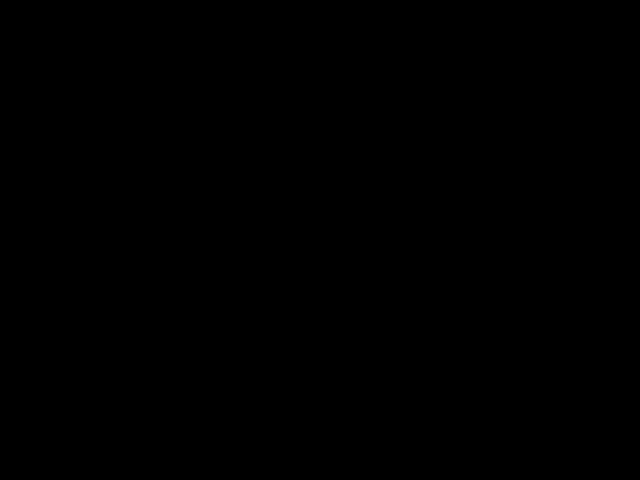

voxel_jepa-CAM_BACK_LEFT/0/target


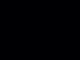

voxel_jepa-CAM_BACK_LEFT/0/predicted


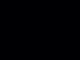

voxel_jepa-CAM_BACK_LEFT/0/color


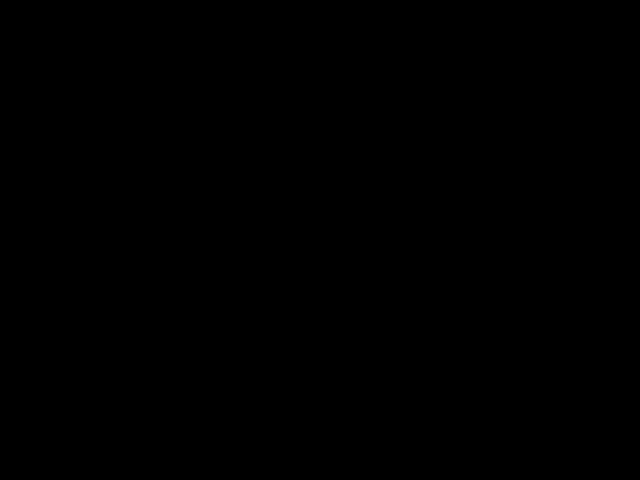

voxel_jepa-CAM_BACK_RIGHT/0/target


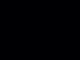

voxel_jepa-CAM_BACK_RIGHT/0/predicted


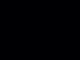

voxel_jepa-CAM_BACK_RIGHT/0/color


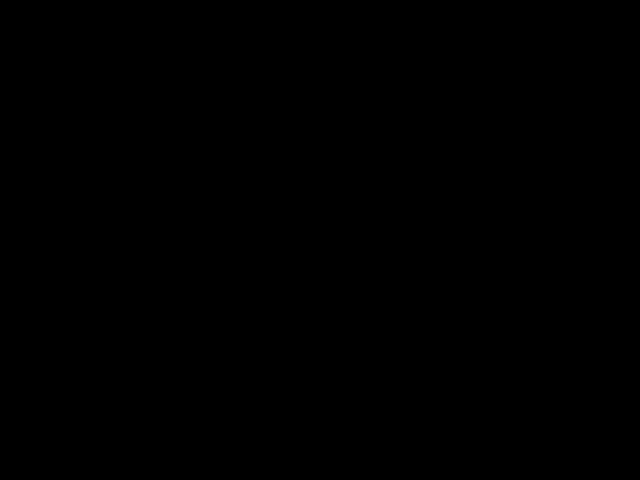

voxel_jepa-grid/1/z


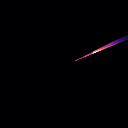

voxel_jepa-CAM_FRONT/1/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT/1/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT/1/target


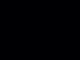

voxel_jepa-CAM_FRONT/1/predicted


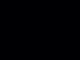

voxel_jepa-CAM_FRONT/1/color


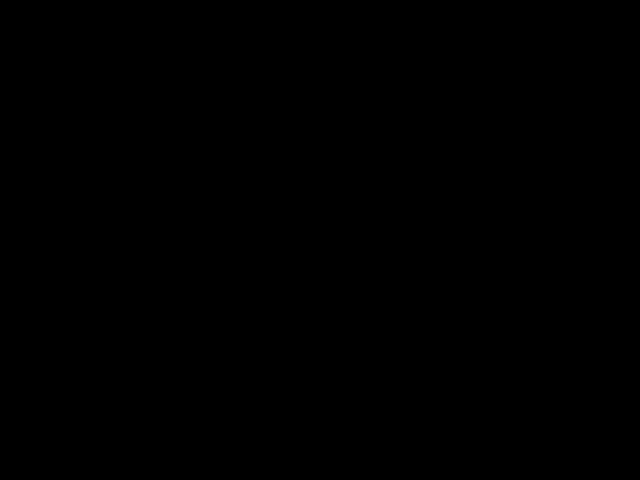

voxel_jepa-CAM_FRONT_LEFT/1/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_LEFT/1/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_LEFT/1/target


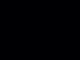

voxel_jepa-CAM_FRONT_LEFT/1/predicted


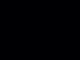

voxel_jepa-CAM_FRONT_LEFT/1/color


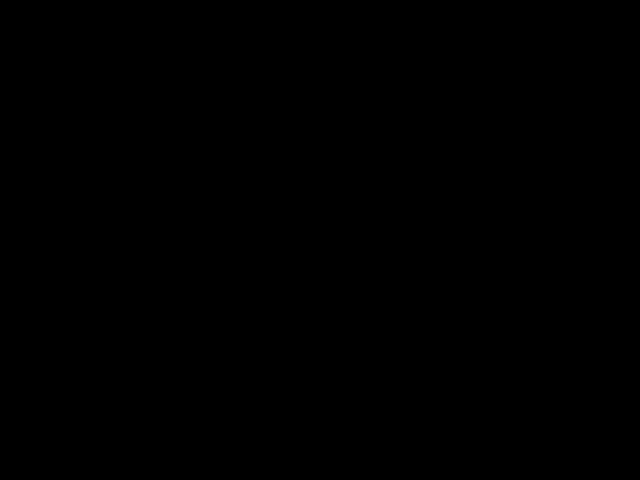

voxel_jepa-CAM_FRONT_RIGHT/1/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_RIGHT/1/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_RIGHT/1/target


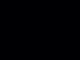

voxel_jepa-CAM_FRONT_RIGHT/1/predicted


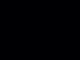

voxel_jepa-CAM_FRONT_RIGHT/1/color


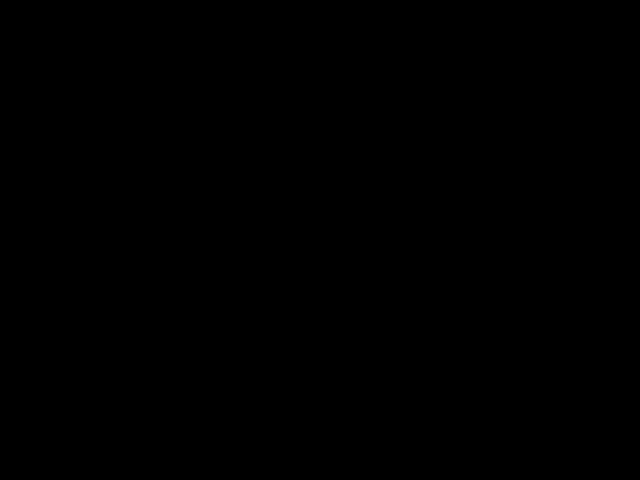

voxel_jepa-CAM_BACK/1/target


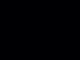

voxel_jepa-CAM_BACK/1/predicted


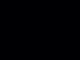

voxel_jepa-CAM_BACK/1/color


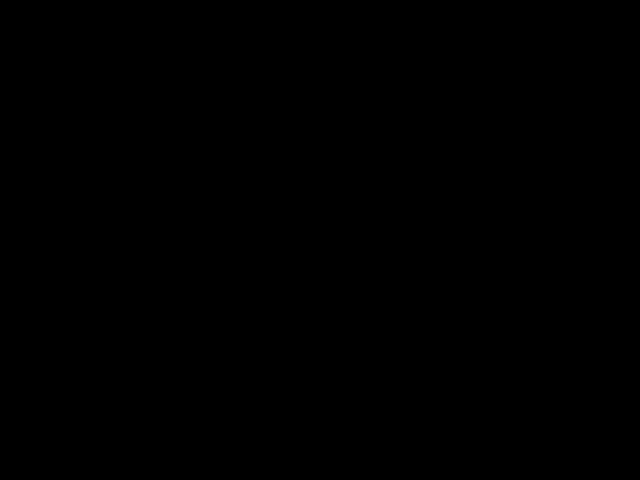

voxel_jepa-CAM_BACK_LEFT/1/target


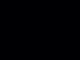

voxel_jepa-CAM_BACK_LEFT/1/predicted


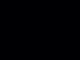

voxel_jepa-CAM_BACK_LEFT/1/color


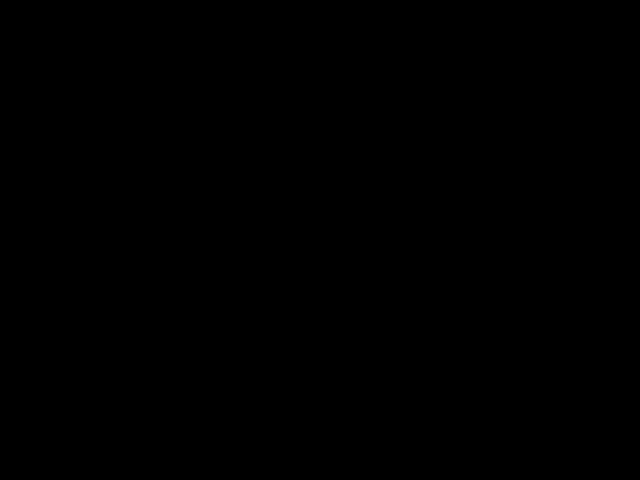

voxel_jepa-CAM_BACK_RIGHT/1/target


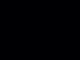

voxel_jepa-CAM_BACK_RIGHT/1/predicted


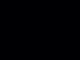

voxel_jepa-CAM_BACK_RIGHT/1/color


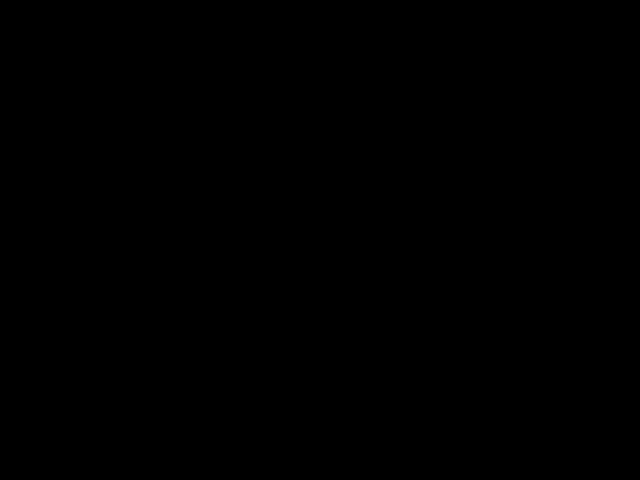

voxel_jepa-grid/2/z


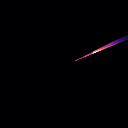

voxel_jepa-CAM_FRONT/2/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT/2/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT/2/target


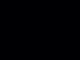

voxel_jepa-CAM_FRONT/2/predicted


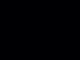

voxel_jepa-CAM_FRONT/2/color


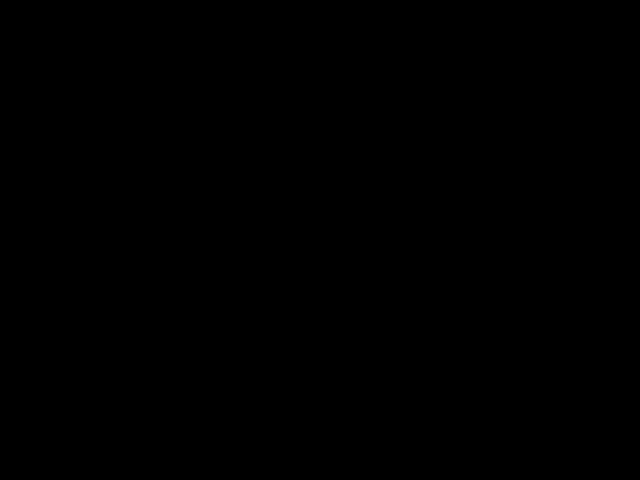

voxel_jepa-CAM_FRONT_LEFT/2/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_LEFT/2/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_LEFT/2/target


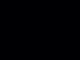

voxel_jepa-CAM_FRONT_LEFT/2/predicted


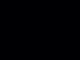

voxel_jepa-CAM_FRONT_LEFT/2/color


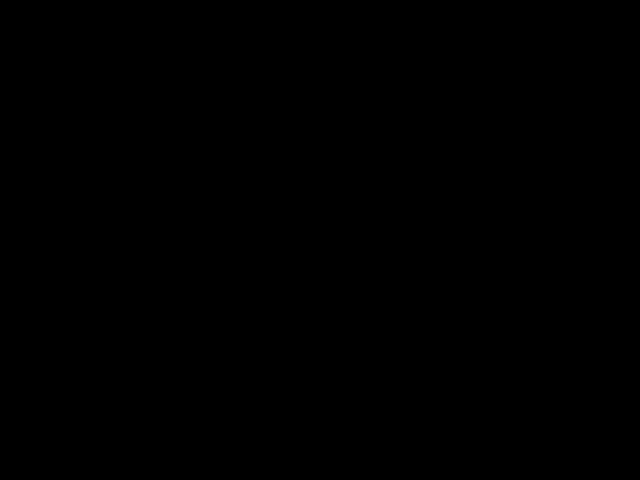

voxel_jepa-CAM_FRONT_RIGHT/2/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_RIGHT/2/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_RIGHT/2/target


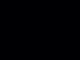

voxel_jepa-CAM_FRONT_RIGHT/2/predicted


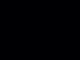

voxel_jepa-CAM_FRONT_RIGHT/2/color


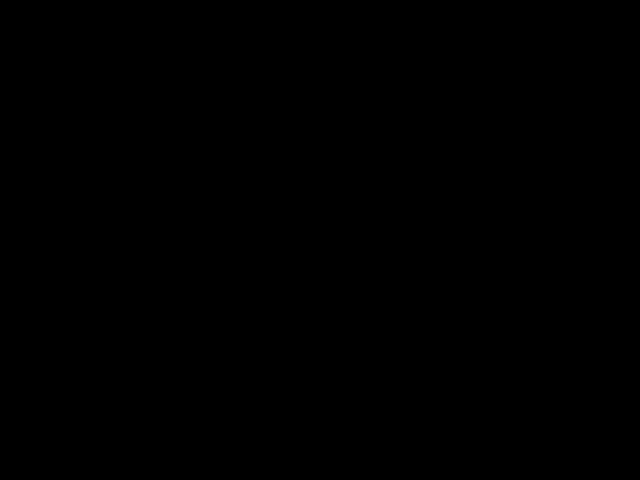

voxel_jepa-CAM_BACK/2/target


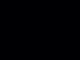

voxel_jepa-CAM_BACK/2/predicted


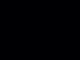

voxel_jepa-CAM_BACK/2/color


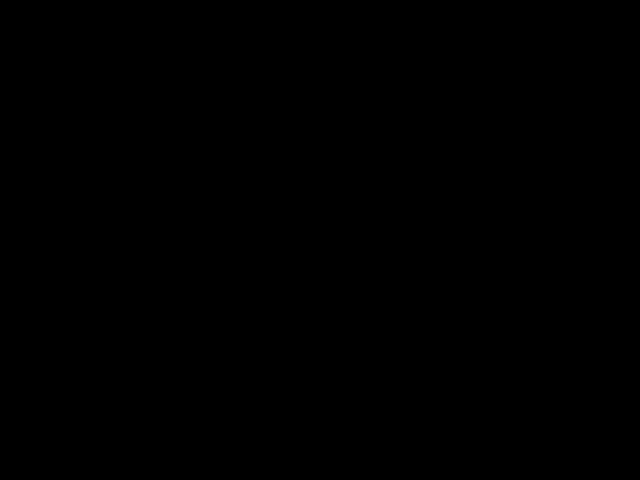

voxel_jepa-CAM_BACK_LEFT/2/target


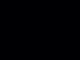

voxel_jepa-CAM_BACK_LEFT/2/predicted


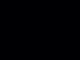

voxel_jepa-CAM_BACK_LEFT/2/color


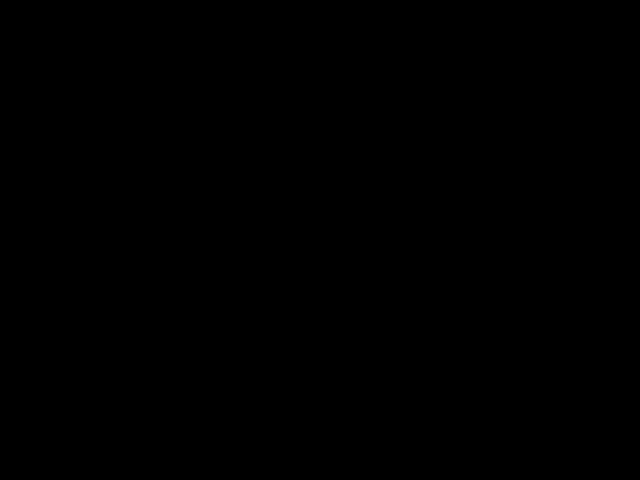

voxel_jepa-CAM_BACK_RIGHT/2/target


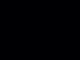

voxel_jepa-CAM_BACK_RIGHT/2/predicted


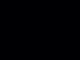

voxel_jepa-CAM_BACK_RIGHT/2/color


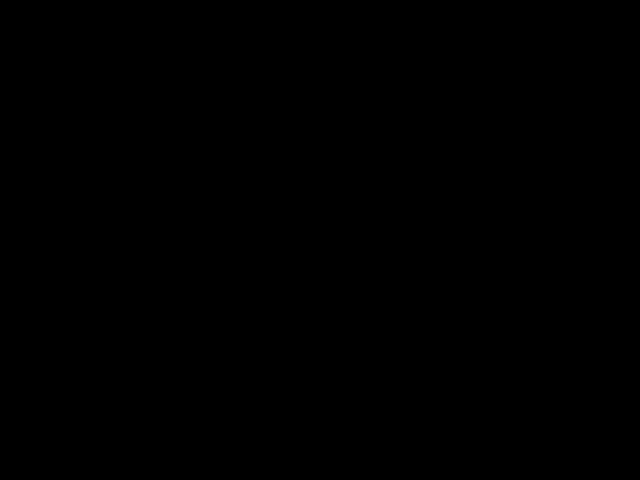

voxel_jepa-grid/3/z


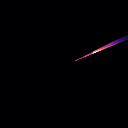

voxel_jepa-CAM_FRONT/3/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT/3/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT/3/target


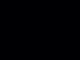

voxel_jepa-CAM_FRONT/3/predicted


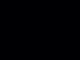

voxel_jepa-CAM_FRONT/3/color


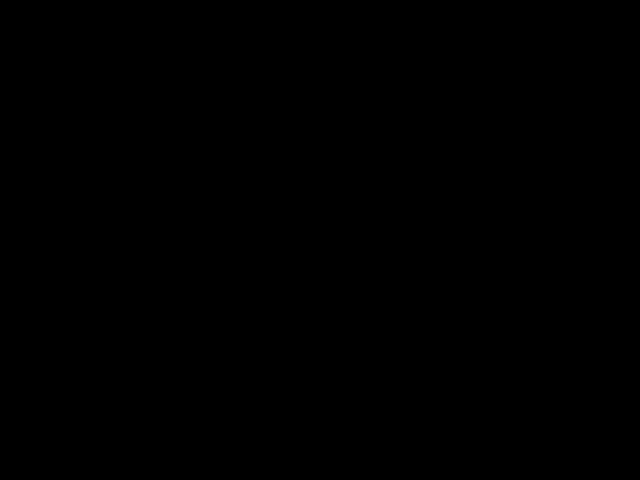

voxel_jepa-CAM_FRONT_LEFT/3/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_LEFT/3/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_LEFT/3/target


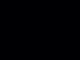

voxel_jepa-CAM_FRONT_LEFT/3/predicted


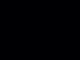

voxel_jepa-CAM_FRONT_LEFT/3/color


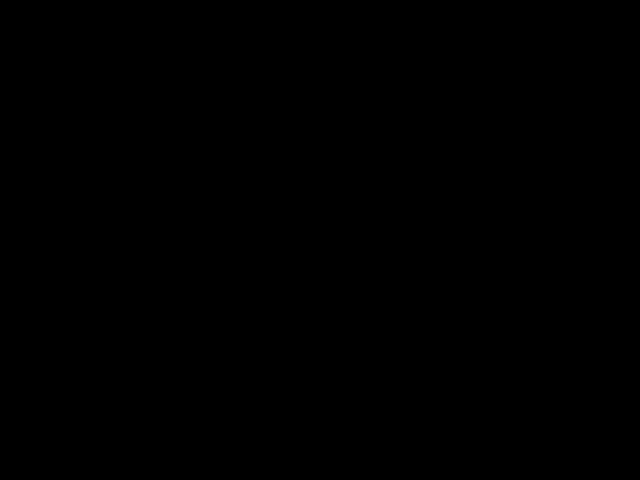

voxel_jepa-CAM_FRONT_RIGHT/3/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_RIGHT/3/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_RIGHT/3/target


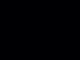

voxel_jepa-CAM_FRONT_RIGHT/3/predicted


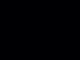

voxel_jepa-CAM_FRONT_RIGHT/3/color


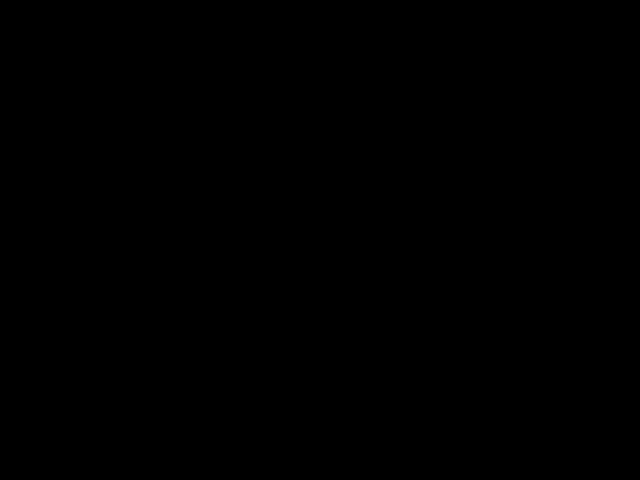

voxel_jepa-CAM_BACK/3/target


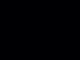

voxel_jepa-CAM_BACK/3/predicted


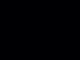

voxel_jepa-CAM_BACK/3/color


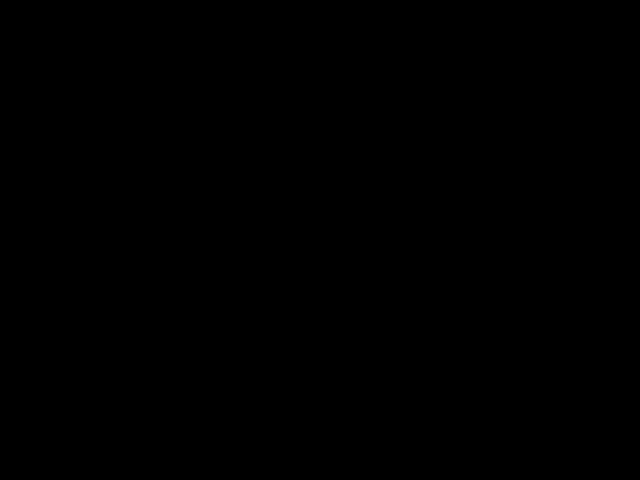

voxel_jepa-CAM_BACK_LEFT/3/target


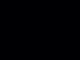

voxel_jepa-CAM_BACK_LEFT/3/predicted


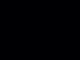

voxel_jepa-CAM_BACK_LEFT/3/color


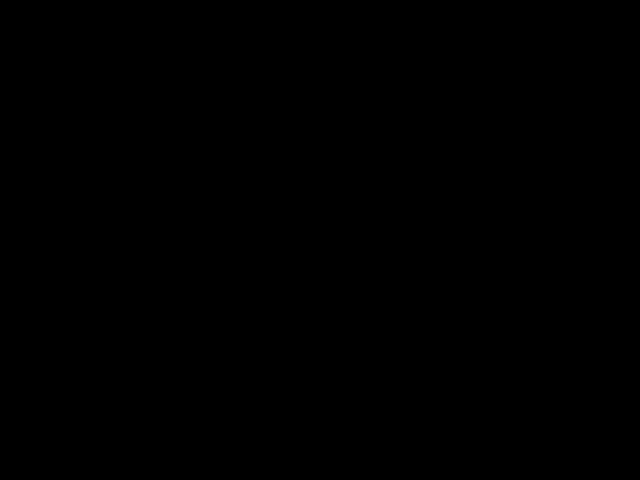

voxel_jepa-CAM_BACK_RIGHT/3/target


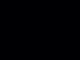

voxel_jepa-CAM_BACK_RIGHT/3/predicted


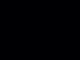

voxel_jepa-CAM_BACK_RIGHT/3/color


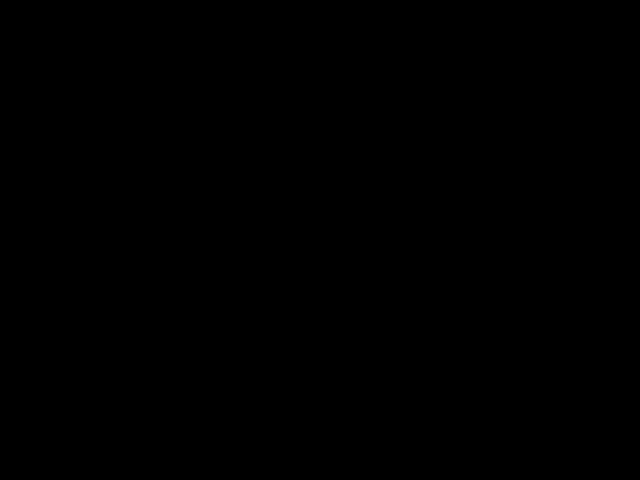

voxel_jepa-grid/4/z


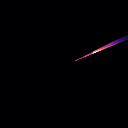

voxel_jepa-CAM_FRONT/4/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT/4/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT/4/target


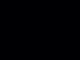

voxel_jepa-CAM_FRONT/4/predicted


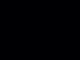

voxel_jepa-CAM_FRONT/4/color


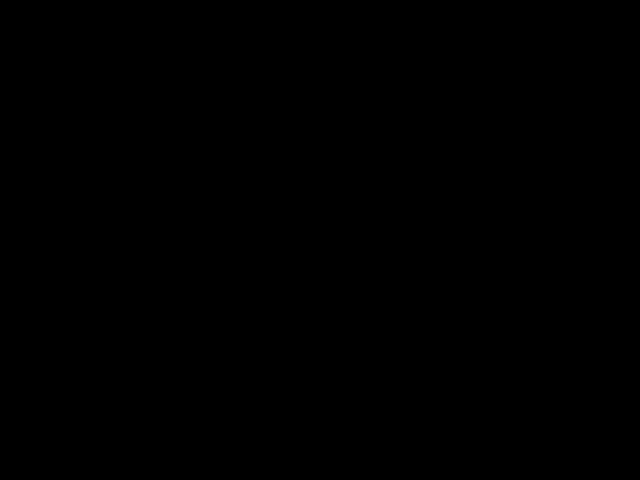

voxel_jepa-CAM_FRONT_LEFT/4/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_LEFT/4/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_LEFT/4/target


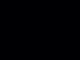

voxel_jepa-CAM_FRONT_LEFT/4/predicted


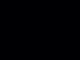

voxel_jepa-CAM_FRONT_LEFT/4/color


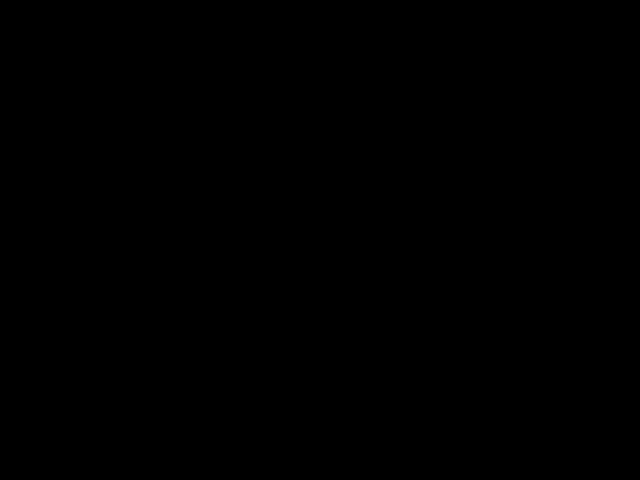

voxel_jepa-CAM_FRONT_RIGHT/4/predicted-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_RIGHT/4/target-minmax {'max': tensor(0.), 'min': tensor(0.), 'mean': tensor(0.)}
voxel_jepa-CAM_FRONT_RIGHT/4/target


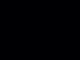

voxel_jepa-CAM_FRONT_RIGHT/4/predicted


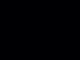

voxel_jepa-CAM_FRONT_RIGHT/4/color


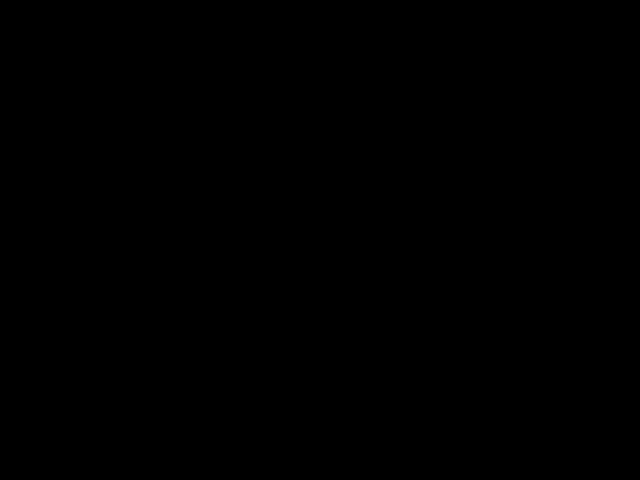

voxel_jepa-CAM_BACK/4/target


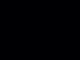

voxel_jepa-CAM_BACK/4/predicted


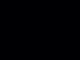

voxel_jepa-CAM_BACK/4/color


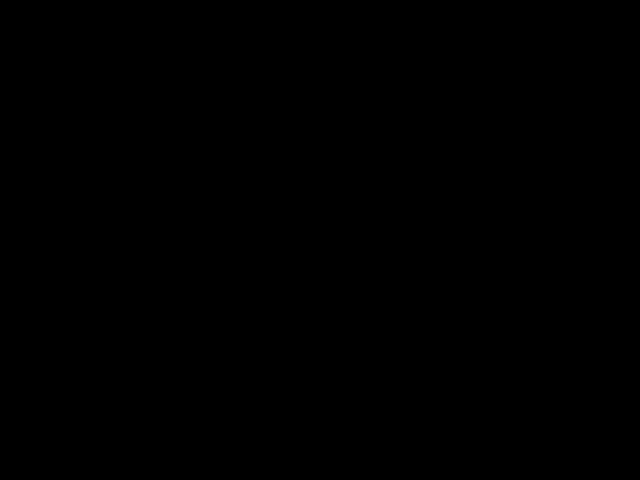

voxel_jepa-CAM_BACK_LEFT/4/target


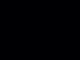

voxel_jepa-CAM_BACK_LEFT/4/predicted


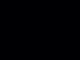

voxel_jepa-CAM_BACK_LEFT/4/color


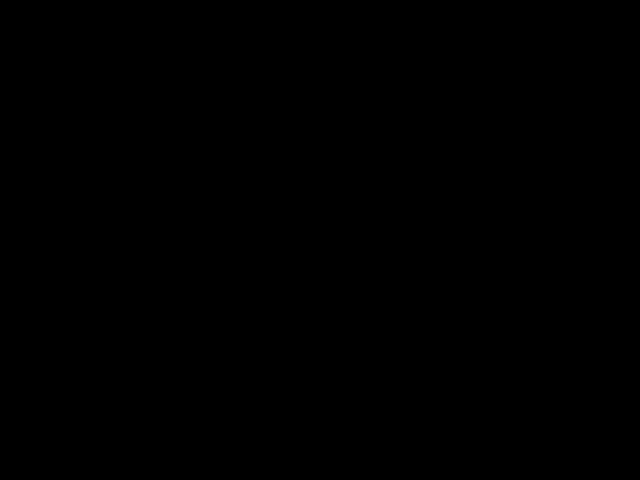

voxel_jepa-CAM_BACK_RIGHT/4/target


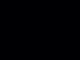

voxel_jepa-CAM_BACK_RIGHT/4/predicted


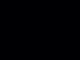

voxel_jepa-CAM_BACK_RIGHT/4/color


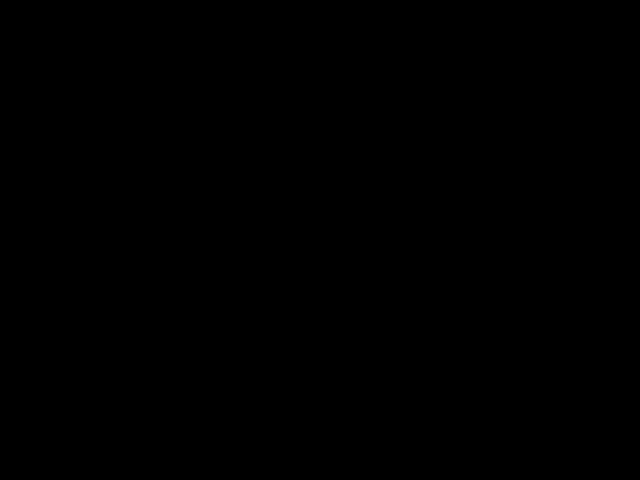

{'voxel_jepa-cam_features/CAM_FRONT/0': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_FRONT_LEFT/0': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_FRONT_RIGHT/0': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_BACK/0': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_BACK_LEFT/0': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_BACK_RIGHT/0': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_FRONT/1': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_FRONT_LEFT/1': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_FRONT_RIGHT/1': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_BACK/1': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_BACK_LEFT/1': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_BACK_RIGHT/1': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_FRONT/2': tensor(0., device='cuda:0'),
 'voxel_jepa-cam_features/CAM_FRONT_LEFT/2': tensor(0., device='c

In [7]:
%autoreload 2
from unittest.mock import MagicMock
from torch.utils.tensorboard import SummaryWriter
import tempfile
from torchvision.transforms.functional import to_pil_image
import os


writer = MagicMock(autospec=SummaryWriter)

out = tempfile.TemporaryDirectory()

def add_image(name: str, img: object, global_step: int):
    if "CAM_FRONT/" in name or "bev" in name or "grid" in name or "dispvoxel" in name or True:
        print(name)
        display(to_pil_image(img))
        
def add_scalar(name: str, val: float, global_step: int):
    if False:
        print(name, val)
    
def add_scalars(name: str, val: float, global_step: int):
    if 'CAM_FRONT' in name:
        print(name, val)
    
writer.add_image.side_effect = add_image
writer.add_scalar.side_effect = add_scalar
writer.add_scalars.side_effect = add_scalars

batch = collate([example]).to(device)
for cam in batch.color:
    batch.color[cam] = torch.full_like(batch.color[cam], fill_value=0, dtype=torch.float32)

FRAME = 0
batch.color["CAM_FRONT"][:, FRAME, :, 280:320, 540:580] = 100.0
#print(batch.color["CAM_FRONT"].shape)

model(batch=batch, global_step=1000, writer=writer, output=out.name)

In [ ]:
frame = batch.color["CAM_FRONT"][0, 0]
print(frame.shape)
display_img(frame)

out = model.camera_encoders["CAM_FRONT"](frame.unsqueeze(0))[0]
print(out.shape)
display_color(out.sum(dim=0))

In [ ]:
T = model.backbone.volume_locator.get_local_to_world_coords_transform().get_matrix().permute(0, 2, 1)
zero = torch.tensor((0,0,0,1.0), device=device)
T.matmul(zero)

In [ ]:
batch.world_to_cam("CAM_FRONT", 2).matmul(zero)

In [ ]:
import torch
from torchdrive.transforms.img import render_color

img = torch.zeros(2,3, device=torch.device('cuda'))
render_color(img)

In [ ]:
import safetensors.torch
import zstd

path = "/mnt/ext3/autolabel/nuscenes/sem_seg/00889f8a9549450aa2f32cf310a3e305.safetensors.zstd"
with open(path, "rb") as f:
    decomp = zstd.ZSTD_uncompress(f.read())
out = safetensors.torch.load(decomp)
front = out['CAM_FRONT'].bfloat16()/255
display_color(front.argmax(dim=0))